<a href="https://colab.research.google.com/github/AEmanuelli/ML_Sorbonne_2023/blob/main/TME_1_Alexis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Q 1.1

In [ ]:
from collections import Counter
import math

def entropie(vect):
    n = len(vect)
    hist = Counter(vect)
    H = 0.0
    #on itère sur les classes de sortie
    for y, count in hist.items():
        p = count / n
        # on ne prend en compte que les classes dans lesquelles on a des exemples 
        if p != 0: 
            H -= p * math.log(p, 2)
    return H


Q 1.2

In [ ]:
def entropie_cond(list_vect):
    n = sum(len(vect) for vect in list_vect)
    H = 0.0
    for vect in list_vect:
        m = len(vect)
        # On ne s'intéresse qu'aux sous partitions non vides (sinon la proportion est de 0 donc de toute façon on ne le prend pas en compte, et ça évite de diviser par 0)
        if m > 0:
            p = len(vect) / n
            H += p * entropie(vect)
    return H


Q 1.3

In [ ]:
import numpy as np
import pickle
# data : tableau ( films , features ) , id2titles : dictionnaire id -> titre ,
# fields : id feature -> nom
[ data , id2titles , fields ] = pickle.load(open("/content/imdb_extrait.pkl", "rb"))
# la derniere colonne est le vote
datax = data[:, :32]
datay = np.array([1 if x[33] > 6.5 else -1 for x in data])

In [ ]:
# On crée trois dictionnaires vides pour stocker les entropies
entropies = {}
entropies_cond = {}
diff_entropies = {}

# On parcourt chaque colonne de notre jeu de données
for i in range(datax.shape[1]):
    # On vérifie si la colonne est entièrement nulle
    if np.array_equal(datax[:,i], np.zeros(len(datax[:,i]))):
        # Si oui, on continue à la colonne suivante
        continue
    else:
        # Si non, on sépare les données en fonction de leur valeur dans cette colonne
        data_plus = [datay[j] for j in range(len(datay)) if datax[j,i] == 1]
        data_moins = [datay[j] for j in range(len(datay)) if datax[j,i] == 0]
        
        # On calcule les entropies pour les données séparées
        entropie_plus = entropie(data_plus)
        entropie_moins = entropie(data_moins)
        entropie_cond_plus = entropie_cond([data_plus, data_moins])
        
        # On stocke les entropies dans les dictionnaires correspondants
        entropies[fields[i]] = (entropie_plus, entropie_moins)
        entropies_cond[fields[i]] = entropie_cond_plus
        diff_entropies[fields[i]] = entropie_plus + entropie_moins - entropie_cond_plus


# On trouve l'attribut avec la plus grande différence d'entropie
best_attribute_index = np.argmax(diff_entropies)
best_attribute_name = fields[best_attribute_index]
# On affiche le résultat
print(f"{best_attribute_name} (difference = {diff_entropies[best_attribute_name]:.4f})")

Sci-Fi (difference = 0.9913)


Une valeur de 0 pour la différence d'entropie signifie que l'attribut ne fournit aucune information supplémentaire pour la classification. Une valeur de 1 signifie qu'il fournit une information maximale pour la classification.

Le meilleur attribut pour la partition est Sci-Fi puisqu'il maximise la différence entre entropie et entropie conditionnelle.

Q 1.4

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier as DTree 
import pydotplus

# Liste de profondeurs pour les arbres
depths = [2, 5, 10]

# Boucle pour entraîner et visualiser les arbres
for depth in depths:
    # Initialisation de l'arbre
    dt = DTree(max_depth=depth, min_samples_split=2)
    
    # Entraînement de l'arbre
    dt.fit(datax, datay)
    
    # Exportation de l'arbre au format Graphviz
    id2genre = [x[1] for x in sorted(fields.items())[:-2]]
    dot_data = export_graphviz(dt, out_file=None, feature_names=id2genre)
    
    # Création de l'objet PDF à partir des données Graphviz
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_pdf(f"tree_{depth}.pdf")


Plus la profondeur de l'arbre augmente, moins d'exemples sont séparés à chaque niveau. 
C’est normal étant donné que plus la profondeur augmente plus la classification devient précise au niveau de 'échantillon étudié.

Q 1.5

In [ ]:
# Liste de profondeurs pour les arbres
depths = [2, 5, 10]

# Boucle pour entraîner et calculer les scores
for depth in depths:
    # Initialisation de l'arbre
    dt = DTree(max_depth=depth, min_samples_split=2)
    
    # Entraînement de l'arbre
    dt.fit(datax, datay)
    
    # Exportation de l'arbre au format Graphviz
    id2genre = [x[1] for x in sorted(fields.items())[:-2]]
    dt.fit(datax ,datay)
    print(dt.score(datax,datay))

Le score augmente avec la profondeur : c'est normal puisque l'on évalue nos résultats sur les données avec lesquelles on a entrainés nos modèles.

Q 1.6 


Non ces scores sont des mauvais indicateurs puisqu'ils reflètent la capacité de l'algorithme à classifier les exemples sur lesquels il s'est entrainé sans que l'on ai d'information sur sa capacité à généraliser. Un indicateur plus fiable serait le score de notre modèle sur un échantillon qu'il n'a pas encore rencontré.

Q 1.7

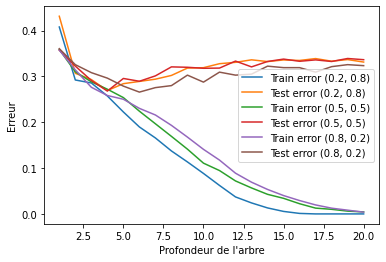

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier as DTree
from sklearn.model_selection import train_test_split



# Définition des profondeurs maximales à tester
max_depths = range(1, 21)

# Définition des différents partages en train/test
split_ratios = [(0.2, 0.8), (0.5, 0.5), (0.8, 0.2)]

# Boucle sur les différents partages
for split_ratio in split_ratios:
    train_errors = []
    test_errors = []
    # Boucle sur les différentes profondeurs
    for max_depth in max_depths:
        # Partitionnement aléatoire en train/test
        X_train, X_test, y_train, y_test = train_test_split(datax, datay, test_size=split_ratio[1], random_state=42)
        # Apprentissage du modèle
        dt = DTree(max_depth=max_depth)
        dt.fit(X_train, y_train)
        # Calcul des erreurs d'apprentissage et de test
        train_error = 1 - dt.score(X_train, y_train)
        test_error = 1 - dt.score(X_test, y_test)
        # Stockage des erreurs
        train_errors.append(train_error)
        test_errors.append(test_error)
    # Tracé des courbes pour ce partage
    plt.plot(max_depths, train_errors, label=f"Train error {split_ratio}")
    plt.plot(max_depths, test_errors, label=f"Test error {split_ratio}")
# Paramètres du graphique

plt.xlabel("Profondeur de l'arbre")
plt.ylabel("Erreur")
plt.legend()
plt.show()


Q 1.8 Dans tout les cas l'erreur d'apprentissage décroit avec la profondeur de l'arbre, tandis que l'erreur de test a une forme de U : elle diminue puis croît à nouveau.

Quand il y a peu d'exemples d'apprentissage, l'erreur d'apprentissage est plus faible tandis que celle de test est plus élevée.

Quand il y a beaucoup d'exemples d'apprentissage, l'erreur d'apprentissage est plus élevée et celle de test est plus faible : l'algorithme généralise donc mieux.



Q 1.9: Les résultats obtenus ne semblent pas très fiables car ils varient beaucoup entre apprentissage et test. Pour améliorer la fiabilité des résultats, on peut réaliser une validation croisée (cross-validation) en utilisant plusieurs partitions différentes et en moyennant les résultats. On peut également augmenter le nombre d'exemples d'apprentissage pour améliorer la stabilité des résultats. Enfin, il peut être utile d'explorer d'autres paramètres de l'algorithme, comme le nombre minimal d'exemples par feuille (min_samples_leaf) ou le critère de split (criterion), afin de trouver le meilleur modèle.

Q 1.10

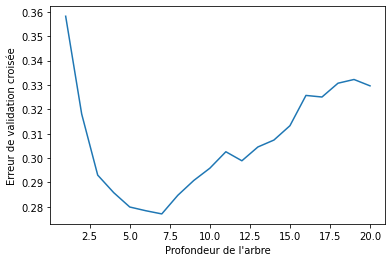

In [ ]:
from sklearn.model_selection import cross_val_score


# Définition des profondeurs maximales à tester
max_depths = range(1, 21)

# Définition de la partition pour la validation croisée
cv_partition = 5

# Stockage des erreurs de validation croisée
cv_errors = []

# Boucle sur les différentes profondeurs
for max_depth in max_depths:
    # Initialisation de l'arbre
    dt = DTree(max_depth=max_depth)
    
    # Calcul des erreurs de validation croisée
    cv_score = cross_val_score(dt, datax, datay, cv=cv_partition, scoring='accuracy')
    cv_error = 1 - cv_score.mean()
    
    # Stockage de l'erreur de validation croisée
    cv_errors.append(cv_error)

# Tracé de la courbe d'erreur de validation croisée
plt.plot(max_depths, cv_errors)
plt.xlabel("Profondeur de l'arbre")
plt.ylabel("Erreur de validation croisée")
plt.show()


la valeur optimale de profondeur de l'arbre est de 7. En desosus on est en sous apprentissage et au dessus en suraprentissage. 